# Imports

In [166]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics

In [167]:
df_car = pd.read_csv('https://raw.githubusercontent.com/pokengineer/DataScience/main/datasets/car_price.csv')
df_car.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


# ETL

In [168]:
def etl_dataset( df ):
    # Torque
    df['RPM'] = df['torque'].str.extract(r'(\d+)rpm', expand=False)
    df['RPM'].fillna(df['torque'].str.extract(r'(\d{1,3}(?:,\d{3})*)\(kgm@ rpm\)', expand=False), inplace=True)
    df['RPM'].fillna(df['torque'].str.extract(r'(\d+) RPM', expand=False), inplace=True)
    df['RPM'].fillna(df['torque'].str.extract(r'(\d+)  rpm ', expand=False), inplace=True)
    df['RPM'].fillna(df['torque'].str.extract(r'(\d+) rpm', expand=False), inplace=True)
    df['TORQUE'] = df['torque'].str.extract(r'(\d+)Nm@', expand=False)
    df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)nm@', expand=False), inplace=True)
    df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+) Nm', expand=False), inplace=True)
    df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)@', expand=False), inplace=True)
    df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)Nm', expand=False), inplace=True)
    df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)  Nm', expand=False), inplace=True)
    df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)NM@', expand=False), inplace=True)
    df['TORQUE'].fillna((df['torque'].str.extract(r'(\d{1,2}(?:[,.]\d{1,2})?)@\s*\d{1,3}(?:,\d{3})*\(kgm@ rpm\)', expand=False)).astype(float) * 9.8, inplace=True)
    df['TORQUE'].fillna((df['torque'].str.extract(r'(\d{1,2}(?:[,.]\d{1,2})?)\s*kgm', expand=False)).astype(float) * 9.8,inplace=True)
    df['RPM'] = df['RPM'].str.replace(',', '').astype(float)
    df['TORQUE'] = df['TORQUE'].astype(float)
    # Brand
    df['BRAND'] = df['name'].astype('str').apply(lambda x: x.split()[0])
    # Milage
    df['MILEAGE'] = (df['mileage'].apply(lambda x: str(x).replace(' kmpl', '').replace(' km/kg', ''))).astype(float)
    # Engine
    df['ENGINE'] = (df['engine'].apply(lambda x: str(x).replace(' CC', ''))).astype(float)
    # Max Power
    df['MAX_POWER'] = df['max_power'].astype(str).apply(lambda x: x.split()[0])
    df.drop(df[df['MAX_POWER'] == 'bhp'].index, inplace=True, axis=0)
    df['MAX_POWER'] = df['MAX_POWER'].astype(float)
    # Drop columns
    return df.drop(['torque', 'name', 'mileage', 'engine', 'max_power'], axis=1)

In [169]:
df_car = etl_dataset( df_car )

<ipython-input-168-96d03e74f920>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RPM'].fillna(df['torque'].str.extract(r'(\d{1,3}(?:,\d{3})*)\(kgm@ rpm\)', expand=False), inplace=True)
<ipython-input-168-96d03e74f920>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

# Analisis del Dataset

In [170]:
# Identificamos las variables categóricas para crear dummies o incluirla de otra forma
categorical = [var for var in df_car.columns if df_car[var].dtype=='O']
print('las variables categoricas son:\n', categorical)
print("\nchequeamos la dimensionalidad de las variables")
for var in categorical:
    print(len(df_car[var].unique()), ' valores unicos en ', var )

las variables categoricas son:
 ['fuel', 'seller_type', 'transmission', 'owner', 'BRAND']

chequeamos la dimensionalidad de las variables
4  valores unicos en  fuel
3  valores unicos en  seller_type
2  valores unicos en  transmission
5  valores unicos en  owner
32  valores unicos en  BRAND


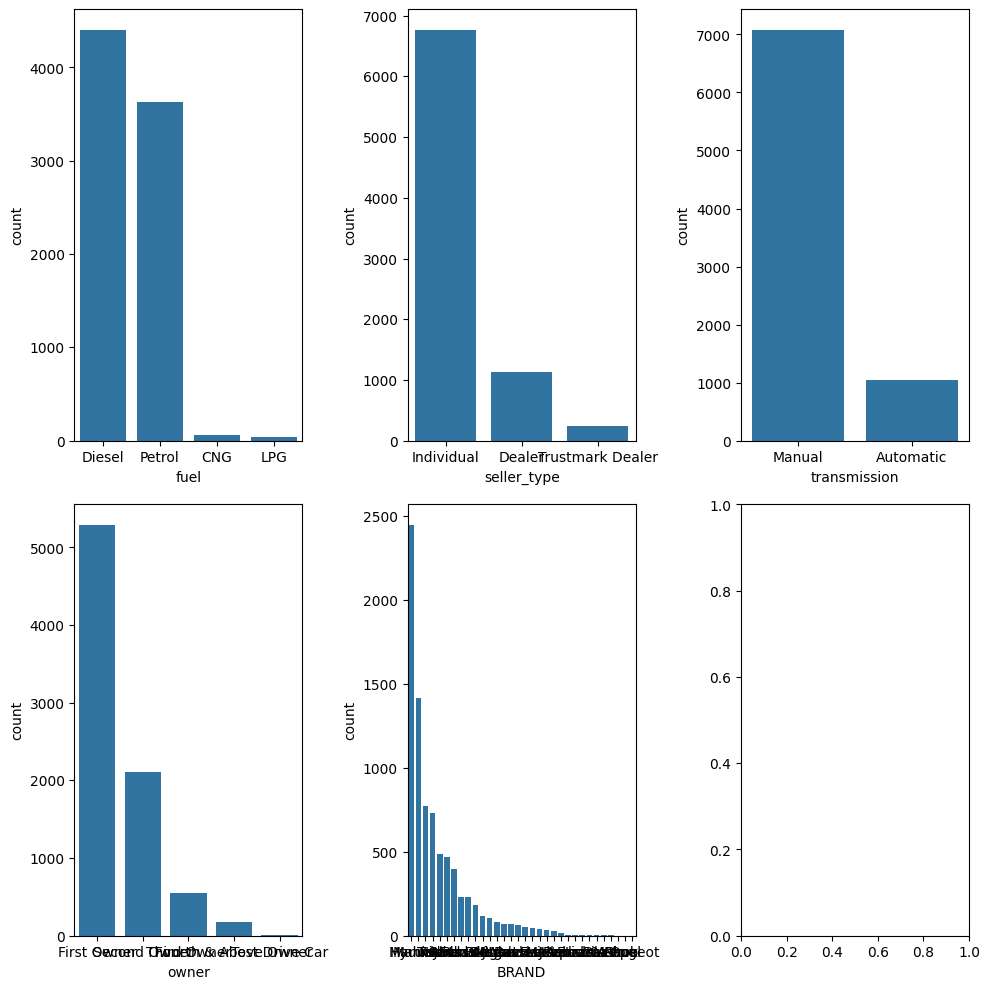

In [171]:
cat_cols_count = len(categorical)
cat_rows = cat_cols_count // 3
cat_rows += 1 if cat_cols_count % 3 != 0 else 0  # Eğer sütun sayısı 3'e tam bölünmüyorsa bir ek satır oluştur.

fig, axes = plt.subplots(cat_rows, 3, figsize=(10, 10), squeeze=True)
axes = axes.flatten()

for i, col in enumerate(categorical):
    sns.countplot(data=df_car, x=col, ax=axes[i], order=df_car[col].value_counts().index)
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

In [172]:
# identificamos las variables numéricas
numerical = [var for var in df_car.columns if df_car[var].dtype!='O']
print('las variables numéricas son:\n', numerical)

las variables numéricas son:
 ['year', 'selling_price', 'km_driven', 'seats', 'RPM', 'TORQUE', 'MILEAGE', 'ENGINE', 'MAX_POWER']


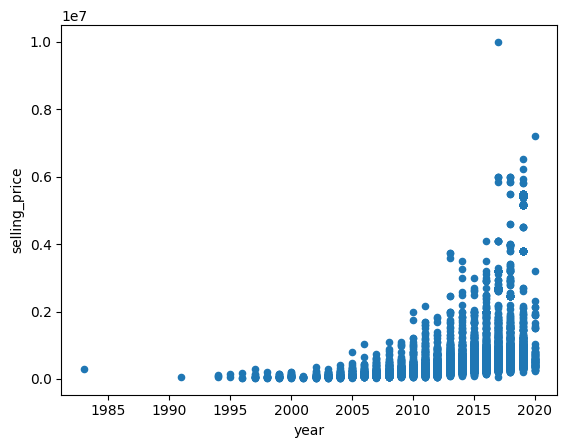

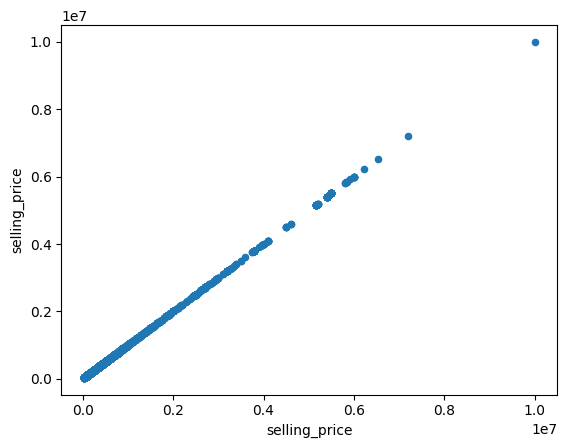

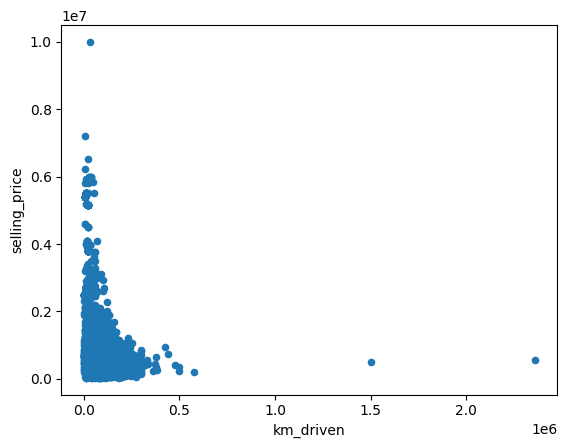

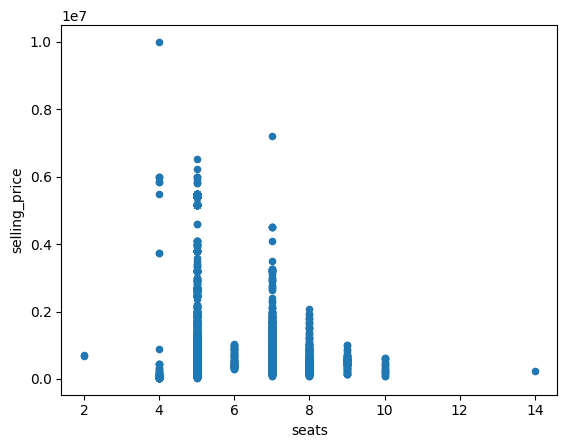

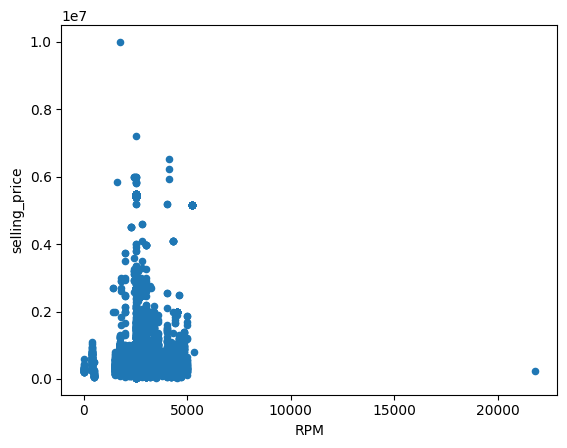

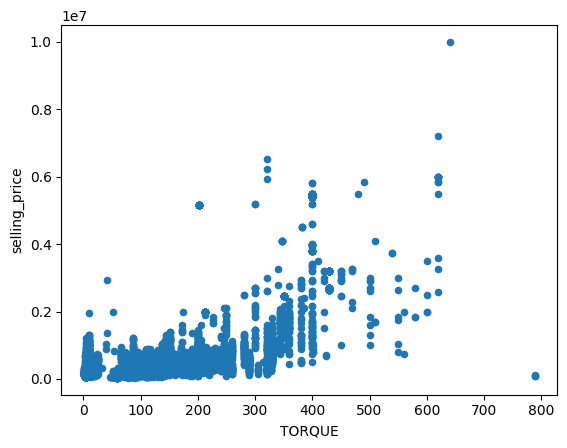

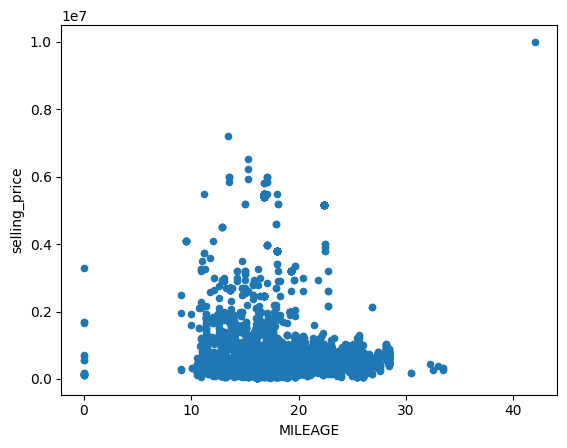

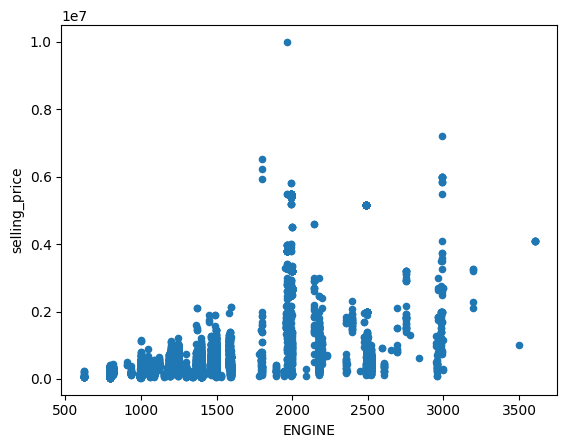

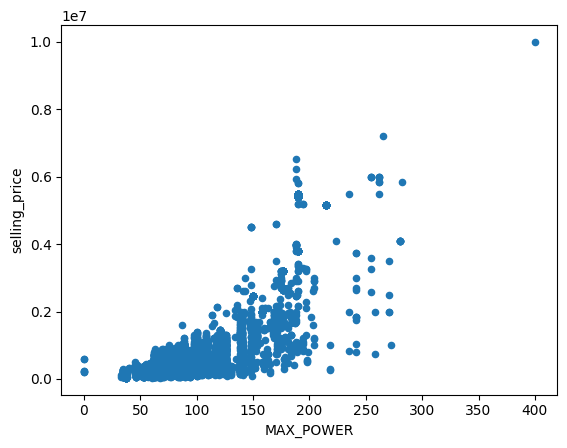

In [173]:
for columna in numerical:
    df_car.plot(x=columna, y='selling_price',kind='scatter')
plt.show()

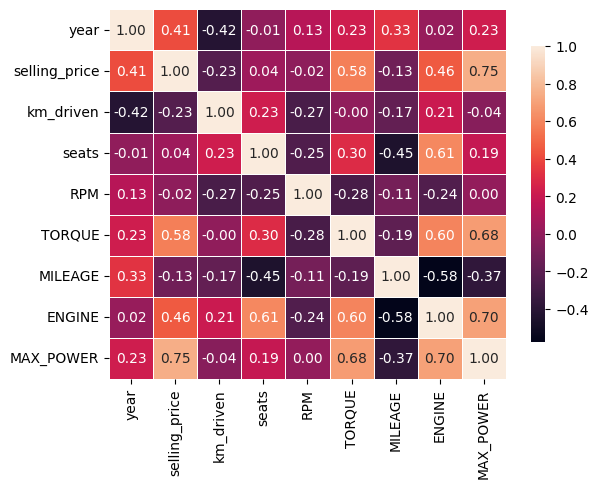

In [174]:
sns.heatmap(df_car[numerical].corr(), annot=True, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .8})
plt.show()

In [175]:
# Verificamos si hay valores nulos para imputar
df_car.isnull().sum()

,0
year,0
selling_price,0
km_driven,0
fuel,0
seller_type,0
transmission,0
owner,0
seats,221
RPM,274
TORQUE,242


# Pipeline

In [176]:
df_car.columns

Index(['year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'seats', 'RPM', 'TORQUE', 'BRAND', 'MILEAGE',
       'ENGINE', 'MAX_POWER'],
      dtype='object')

In [177]:
X_car = df_car.drop(columns="selling_price")
y_car = df_car["selling_price"]
X_train, X_test, y_train, y_test = train_test_split(X_car, y_car,test_size=0.3, random_state=0)

X = ['TORQUE']
pl = Pipeline([
    ("selector", ColumnTransformer([("selector", "passthrough", X )], remainder="drop")),
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('regressor', LinearRegression())
])

pl.fit( X_train, y_train )

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['TORQUE'])])),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

# Regresion Lineal Simple

In [178]:
predicted = pl.predict(X_test)

In [179]:
pl['regressor'].n_features_in_

1

In [180]:
# score devuelve coeficiente de determinación, denominado R²
print( "R²: " + str( pl.score(X_test,y_test) ))

R²: 0.32959400341891143


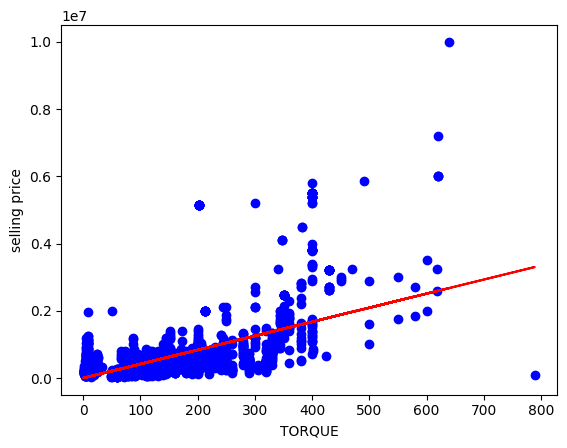

In [181]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Create scatter plot
plt.scatter( X_test['TORQUE'],y_test, color="blue")

# Create line plot
plt.plot( X_test['TORQUE'],predicted,color="red")
plt.xlabel("TORQUE")
plt.ylabel("selling price")

# Display the plot
plt.show()

# Ejercicio
- probar el modelo con la variable de mayor correlacion, MAX_POWER
- imputar a la media los valores nulos de MAX POWER dentro de la funcion de preparacion de datos
- realizar un modelo de regresion lineal que use más de una columna

# Punto 1:
- probar el modelo con la variable de mayor correlacion, MAX_POWER

In [182]:
df_car = pd.read_csv('https://raw.githubusercontent.com/pokengineer/DataScience/main/datasets/car_price.csv')
df_car = etl_dataset( df_car )
X_car = df_car.drop(columns="selling_price")
y_car = df_car["selling_price"]
X_train, X_test, y_train, y_test = train_test_split(X_car, y_car,test_size=0.3, random_state=0)

X = ['MAX_POWER']
pl = Pipeline([
    ("selector", ColumnTransformer([("selector", "passthrough", X )], remainder="drop")),
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('regressor', LinearRegression())
])

pl.fit( X_train, y_train )

<ipython-input-168-96d03e74f920>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RPM'].fillna(df['torque'].str.extract(r'(\d{1,3}(?:,\d{3})*)\(kgm@ rpm\)', expand=False), inplace=True)
<ipython-input-168-96d03e74f920>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['MAX_POWER'])])),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [183]:
predicted = pl.predict(X_test)

In [184]:
pl['regressor'].n_features_in_

1

In [185]:
# score devuelve coeficiente de determinación, denominado R²
print( "R²: " + str( pl.score(X_test,y_test) ))

R²: 0.5910847422997841


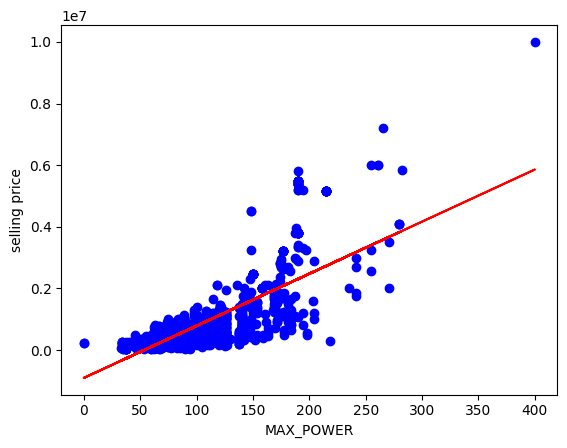

In [186]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Create scatter plot
plt.scatter( X_test['MAX_POWER'],y_test, color="blue")

# Create line plot
plt.plot( X_test['MAX_POWER'],predicted,color="red")
plt.xlabel("MAX_POWER")
plt.ylabel("selling price")

# Display the plot
plt.show()

# Punto 2:
imputar a la media los valores nulos de MAX POWER dentro de la funcion de preparacion de datos

In [187]:
df_car = pd.read_csv('https://raw.githubusercontent.com/pokengineer/DataScience/main/datasets/car_price.csv')
df_car = etl_dataset( df_car )
X_car = df_car.drop(columns="selling_price")
y_car = df_car["selling_price"]
X_train, X_test, y_train, y_test = train_test_split(X_car, y_car,test_size=0.3, random_state=0)

X = ['MAX_POWER']
pl = Pipeline([
    ("selector", ColumnTransformer([("selector", "passthrough", X )], remainder="drop")),
    ("imputer",SimpleImputer(strategy="median")),
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('regressor', LinearRegression())
])

pl.fit( X_train, y_train )

<ipython-input-168-96d03e74f920>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RPM'].fillna(df['torque'].str.extract(r'(\d{1,3}(?:,\d{3})*)\(kgm@ rpm\)', expand=False), inplace=True)
<ipython-input-168-96d03e74f920>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['MAX_POWER'])])),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [188]:
predicted = pl.predict(X_test)

In [189]:
pl['regressor'].n_features_in_

1

In [190]:
# score devuelve coeficiente de determinación, denominado R²
print( "R²: " + str( pl.score(X_test,y_test) ))

R²: 0.588996608772123


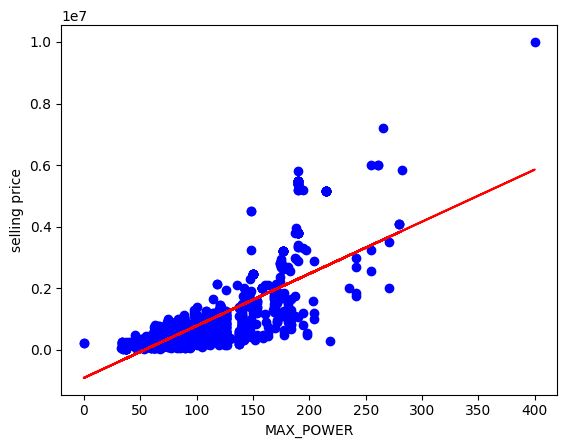

In [191]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Create scatter plot
plt.scatter( X_test['MAX_POWER'],y_test, color="blue")

# Create line plot
plt.plot( X_test['MAX_POWER'],predicted,color="red")
plt.xlabel("MAX_POWER")
plt.ylabel("selling price")

# Display the plot
plt.show()

# Punto 3:
realizar un modelo de regresion lineal que use más de una columna

In [192]:
df_car = pd.read_csv('https://raw.githubusercontent.com/pokengineer/DataScience/main/datasets/car_price.csv')
df_car = etl_dataset( df_car )
X_car = df_car.drop(columns="selling_price")
y_car = df_car["selling_price"]
X_train, X_test, y_train, y_test = train_test_split(X_car, y_car,test_size=0.3, random_state=0)

X = ['MAX_POWER', 'ENGINE', 'year']
pl = Pipeline([
    ("selector", ColumnTransformer([("selector", "passthrough", X )], remainder="drop")),
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('regressor', LinearRegression())
])

pl.fit( X_train, y_train )

<ipython-input-168-96d03e74f920>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RPM'].fillna(df['torque'].str.extract(r'(\d{1,3}(?:,\d{3})*)\(kgm@ rpm\)', expand=False), inplace=True)
<ipython-input-168-96d03e74f920>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['MAX_POWER', 'ENGINE',
                                                   'year'])])),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [193]:
predicted = pl.predict(X_test)

In [194]:
pl['regressor'].n_features_in_

3

In [195]:
# score devuelve coeficiente de determinación, denominado R²
print( "R²: " + str( pl.score(X_test,y_test) ))

R²: 0.6494250623513749


In [196]:
from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(y_test, predicted)
# Calculo el R2 ajustado
n = X_test.shape[0]
p = len(X_test.columns)
r2_ajustado = 1 - ( (1-r2) * ( (n-1) / ( n-p-1 ) ) )

# Muestro los coeficientes
print('Coeficiente de determinación R2: %.4f'% r2)
print('Coeficiente de determinación ajustado: %.4f'% r2_ajustado)

Coeficiente de determinación R2: 0.6494
Coeficiente de determinación ajustado: 0.6475
